# Libraries

In [35]:
# Libraries used:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import ast

sns.set_style("whitegrid")

warnings.filterwarnings('ignore')



# Question 1


1. Data Structure (df.info()) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   in

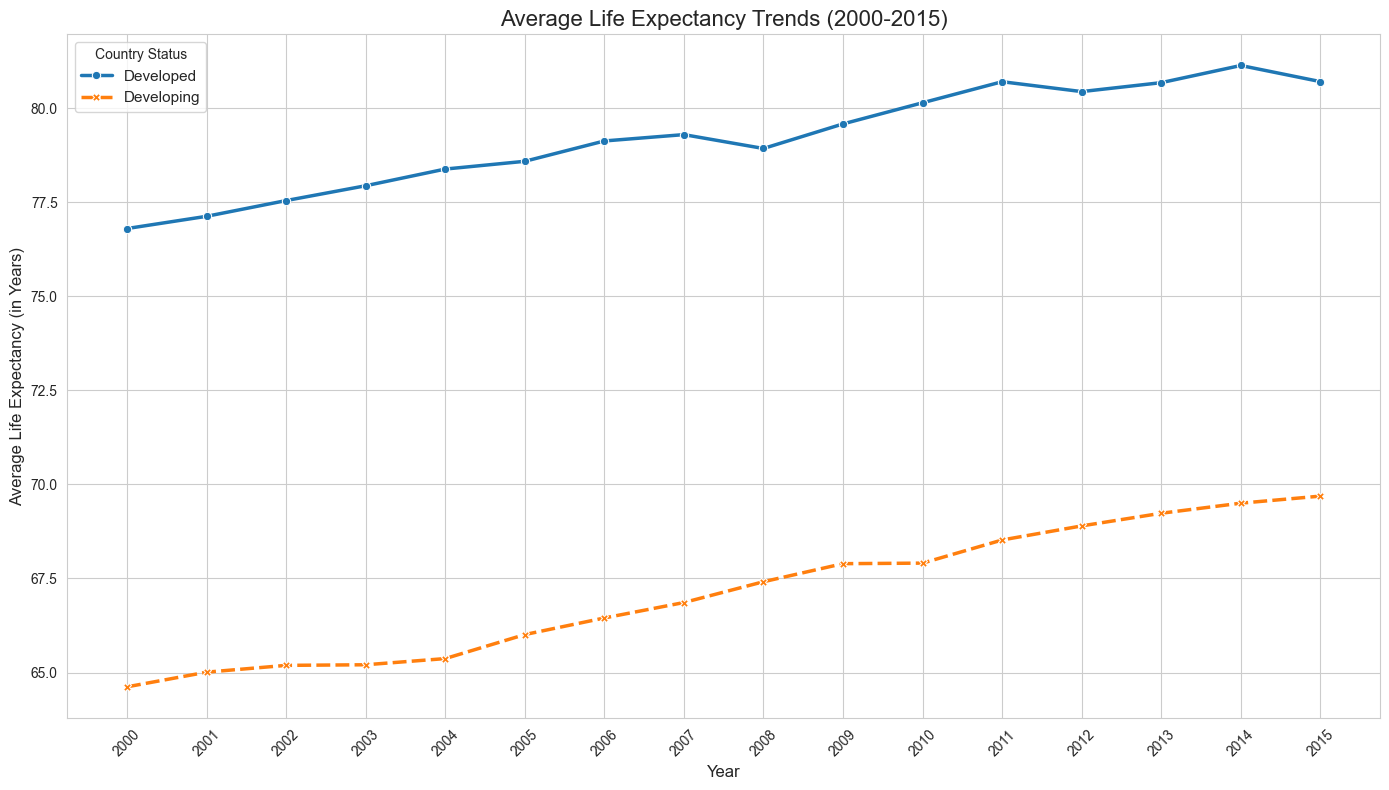

In [36]:


# Load the dataset
file_path = "Life Expectancy Data.csv"
df = None
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
else:

    df.columns = df.columns.str.strip()


    print("1. Data Structure (df.info()) ")
    df.info()

    #  Summary statistics
    print("\n 2. Summary Statistics (df.describe()) ")
    print(df.describe().T)
    
    print("\n 3. Averaging Data ")
    # Average the yearly life expectancy for developing and developed countries
    yearly_avg = df.groupby(['Year', 'Status'])['Life expectancy'].mean().reset_index()
    print("First 5 rows of the averaged data:")
    print(yearly_avg.head())

    # Plot yearly expectancy trends 
 
    plt.figure(figsize=(14, 8))
    
    # Create the line plot
    plot = sns.lineplot(
        data=yearly_avg,
        x='Year',
        y='Life expectancy',
        hue='Status',    
        style='Status',  
        markers=True,
        linewidth=2.5
    )
    
    plt.title('Average Life Expectancy Trends (2000-2015)', fontsize=16)
    plt.ylabel('Average Life Expectancy (in Years)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    # Ensure all years are shown as x-ticks
    plt.xticks(ticks=df['Year'].unique(), rotation=45)
    plt.legend(title='Country Status', fontsize=11)
    plt.tight_layout()

# QUestion 2


Dropped 0 rows where 'Life expectancy' was missing.

 Q2: Part 1: Missing Value Proportions 
|                                 |   Missing Value % |
|:--------------------------------|------------------:|
| Population                      |         21.9945   |
| Hepatitis B                     |         18.8866   |
| Vaccination_Coverage_Index      |         18.8866   |
| GDP                             |         15.1298   |
| Total expenditure               |          7.71858  |
| Alcohol                         |          6.59153  |
| Schooling                       |          5.46448  |
| Education_Income_Index          |          5.46448  |
| Income composition of resources |          5.46448  |
| BMI                             |          1.0929   |
| thinness 5-9 years              |          1.0929   |
| thinness  1-19 years            |          1.0929   |
| Diphtheria                      |          0.648907 |
| Polio                           |          0.648907 |

 Q2: Part 

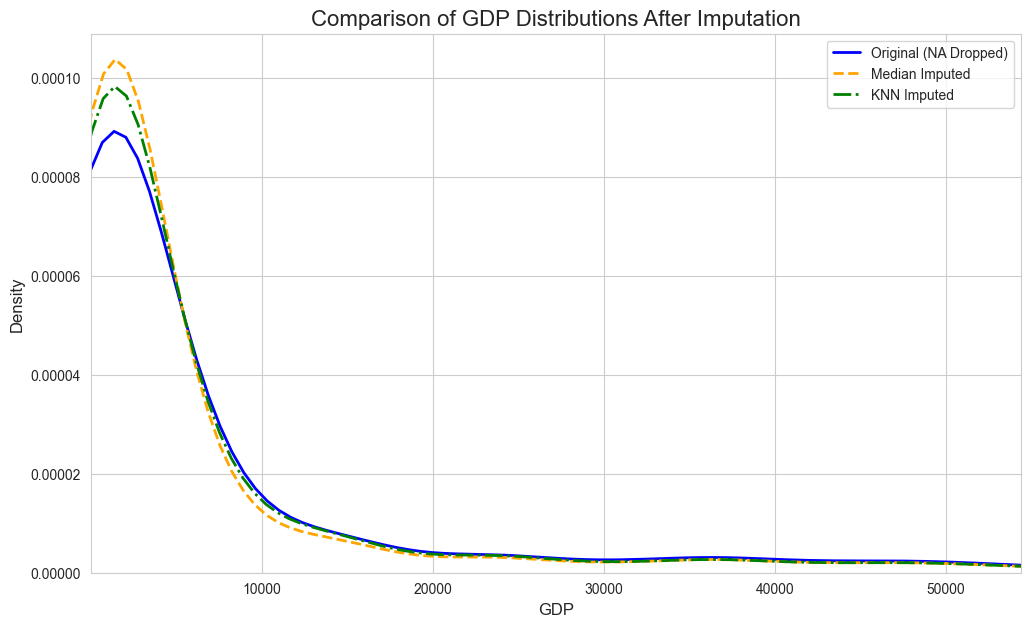

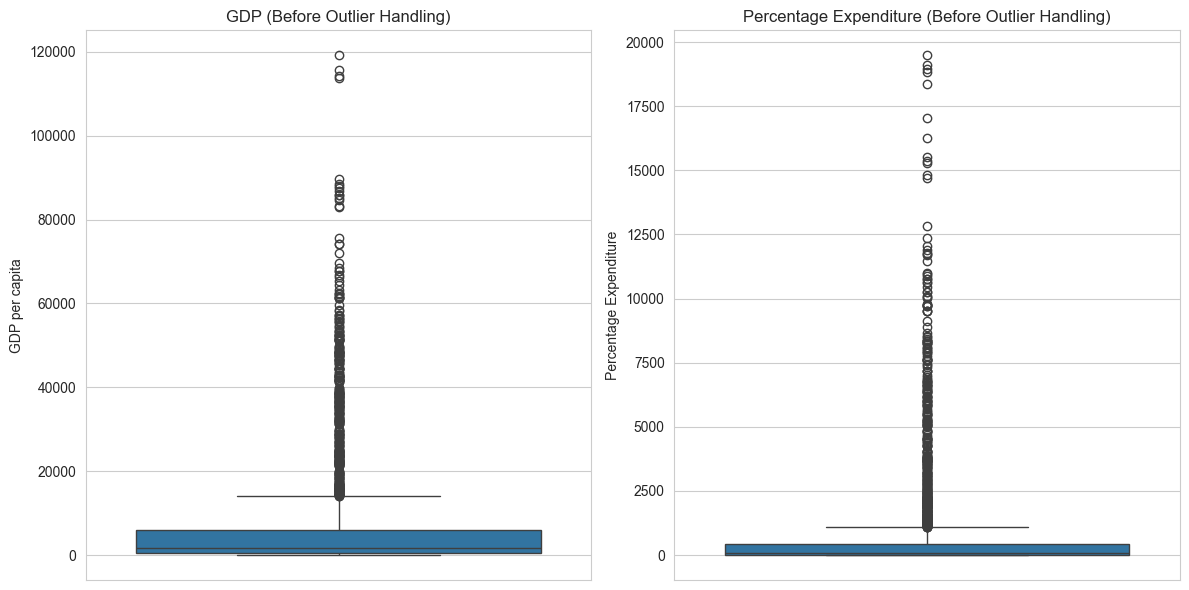

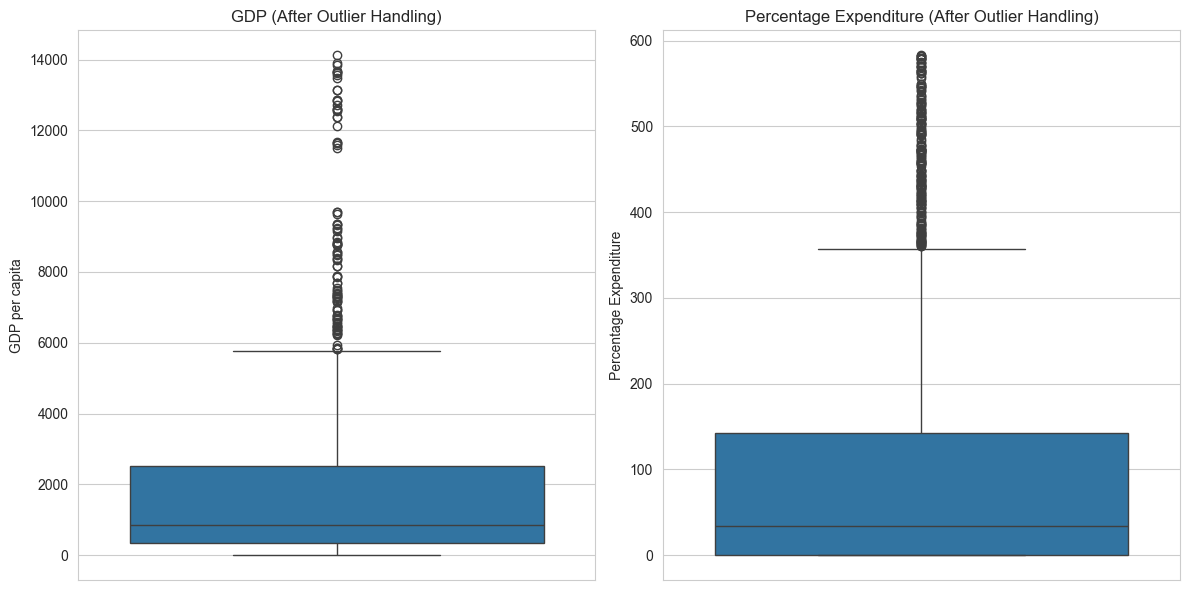

In [46]:
# CRITICAL STEP: Drop rows where the target variable 'Life expectancy' is missing
original_rows = len(df)
df.dropna(subset=['Life expectancy'], inplace=True)
print(f"Dropped {original_rows - len(df)} rows where 'Life expectancy' was missing.")

#  2. Determine Missing Value Proportions 
print("\n Q2: Part 1: Missing Value Proportions ")
missing_proportions = (df.isnull().sum() / len(df)) * 100
missing_proportions = missing_proportions[missing_proportions > 0].sort_values(ascending=False)

if missing_proportions.empty:
    print("No missing values after dropping target NaNs.")
else:
    print(missing_proportions.to_frame(name="Missing Value %").to_markdown())

#  3. Compare Imputation Methods (Median vs. KNN) for GDP 
print("\n Q2: Part 2: Imputation Comparison for GDP ")

# Method 1: Median Imputation
df_median = df.copy()
gdp_median = df_median['GDP'].median()

df_median['GDP'].fillna(gdp_median, inplace=True)

print("\n Stats after Median Imputation ")
print(df_median['GDP'].describe())

# Method 2: KNN Imputation
df_knn = df.copy()
numeric_cols = df.select_dtypes(include=np.number).columns.drop(['Year'])

scaler = StandardScaler()
scaler.fit(df_knn[numeric_cols])
df_knn_scaled = pd.DataFrame(scaler.transform(df_knn[numeric_cols]), columns=numeric_cols)

imputer = KNNImputer(n_neighbors=5)
df_knn_imputed_scaled = pd.DataFrame(imputer.fit_transform(df_knn_scaled), columns=numeric_cols)

df_knn_imputed = pd.DataFrame(scaler.inverse_transform(df_knn_imputed_scaled), columns=numeric_cols)

print("\n Stats after KNN Imputation ")
print(df_knn_imputed['GDP'].describe())

# Plotting the distributions for comparison
plt.figure(figsize=(12, 7))
sns.kdeplot(df['GDP'].dropna(), label='Original (NA Dropped)', color='blue', linewidth=2)
sns.kdeplot(df_median['GDP'], label='Median Imputed', color='orange', linestyle='--', linewidth=2)
sns.kdeplot(df_knn_imputed['GDP'], label='KNN Imputed', color='green', linestyle='-.', linewidth=2)
plt.title('Comparison of GDP Distributions After Imputation', fontsize=16)
plt.xlabel('GDP', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.xlim(left=df['GDP'].min(), right=df['GDP'].quantile(0.98)) 

#  4. Detect and Handle Outliers (GDP & percentage expenditure) 
print("\n Q2: Part 3: Outlier Detection and Handling ")

# Plotting Boxplots BEFORE handling outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['GDP'])
plt.title('GDP (Before Outlier Handling)')
plt.ylabel('GDP per capita')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['percentage expenditure'])
plt.title('Percentage Expenditure (Before Outlier Handling)')
plt.ylabel('Percentage Expenditure')
plt.tight_layout()

# Removing Outliers using the 1.5 * IQR Rule
df_no_outliers = df.copy()

# Handle 'GDP'
Q1_gdp = df_no_outliers['GDP'].quantile(0.25)
Q3_gdp = df_no_outliers['GDP'].quantile(0.75)
IQR_gdp = Q3_gdp - Q1_gdp
lower_bound_gdp = Q1_gdp - 1.5 * IQR_gdp
upper_bound_gdp = Q3_gdp + 1.5 * IQR_gdp

is_gdp_outlier = (df_no_outliers['GDP'] < lower_bound_gdp) | (df_no_outliers['GDP'] > upper_bound_gdp)
df_no_outliers = df_no_outliers[~is_gdp_outlier | df_no_outliers['GDP'].isnull()]


# Handle 'percentage expenditure'
Q1_pe = df_no_outliers['percentage expenditure'].quantile(0.25)
Q3_pe = df_no_outliers['percentage expenditure'].quantile(0.75)
IQR_pe = Q3_pe - Q1_pe
lower_bound_pe = Q1_pe - 1.5 * IQR_pe
upper_bound_pe = Q3_pe + 1.5 * IQR_pe

is_pe_outlier = (df_no_outliers['percentage expenditure'] < lower_bound_pe) | (df_no_outliers['percentage expenditure'] > upper_bound_pe)
df_no_outliers = df_no_outliers[~is_pe_outlier]

print(f"Original row count: {len(df)}. After outlier removal: {len(df_no_outliers)}.")

# Plotting Boxplots AFTER handling outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_no_outliers['GDP'])
plt.title('GDP (After Outlier Handling)')
plt.ylabel('GDP per capita')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_no_outliers['percentage expenditure'])
plt.title('Percentage Expenditure (After Outlier Handling)')
plt.ylabel('Percentage Expenditure')

plt.tight_layout()


# QUestion 3

 Q3: Part 1: Feature Engineering 
Created new features: 'Infant_Survival_Rate', 'Vaccination_Coverage_Index', 'Education_Income_Index'


Infant_Survival_Rate  Vaccination_Coverage_Index  Education_Income_Index
0                 0.938                   45.333333                  4.8379
1                 0.936                   60.666667                  4.7600
2                 0.934                   63.333333                  4.6530
3                 0.931                   67.000000                  4.5374
4                 0.929                   68.000000                  4.3130


 Q3: Part 2: Plotting Feature Distributions 

 Q3: Part 3: Correlation Analysis 

 Correlations with 'Life expectancy' 

Strongest Positive Correlations:
|                                 |   Positive Corr. |
|:--------------------------------|-----------------:|
| Education_Income_Index          |         0.78625  |
| Schooling                       |         0.751975 |
| Income composition of resources |         0.724776 |
| BMI                             |         0.567694 |
| Diphtheria                      |         0.479495 |

Strongest Negative Correlations:
|                      |   Negative Corr. |
|:---------------------|-----------------:|
| under-five deaths    |        -0.222529 |
| thinness 5-9 years   |        -0.471584 |
| thinness  1-19 years |        -0.477183 |
| HIV/AIDS             |        -0.556556 |
| Adult Mortality      |        -0.696359 |


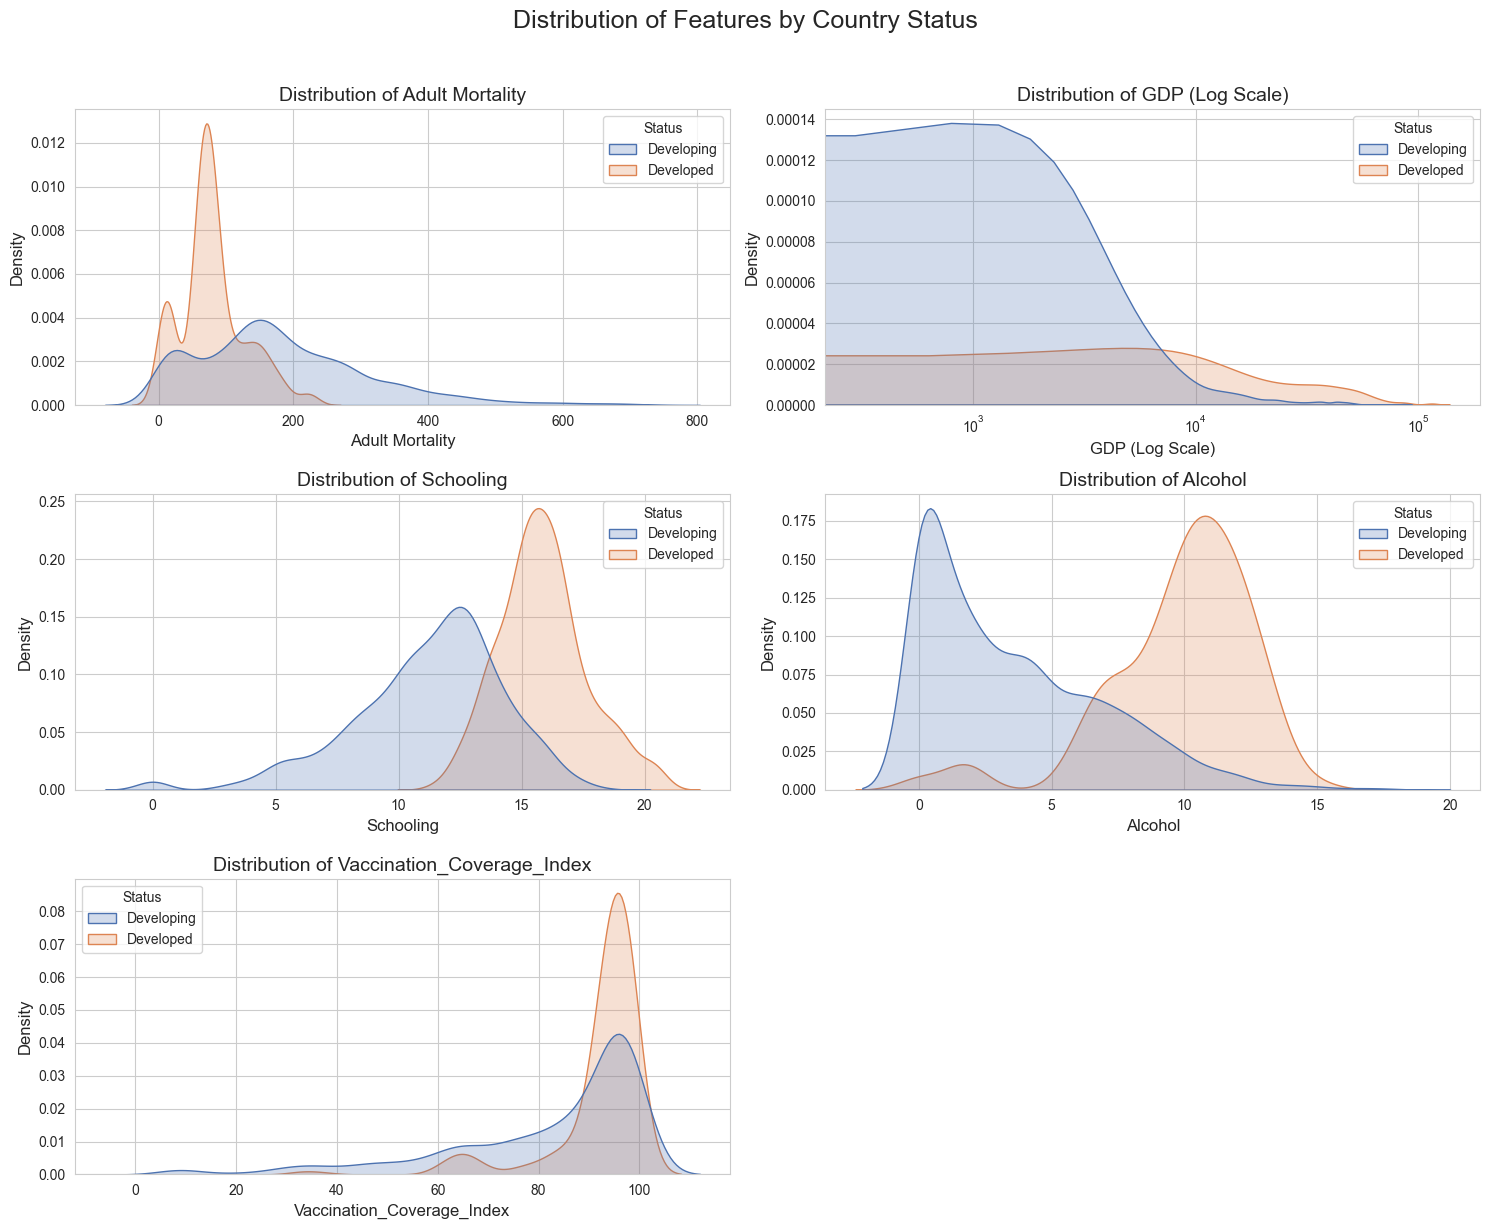

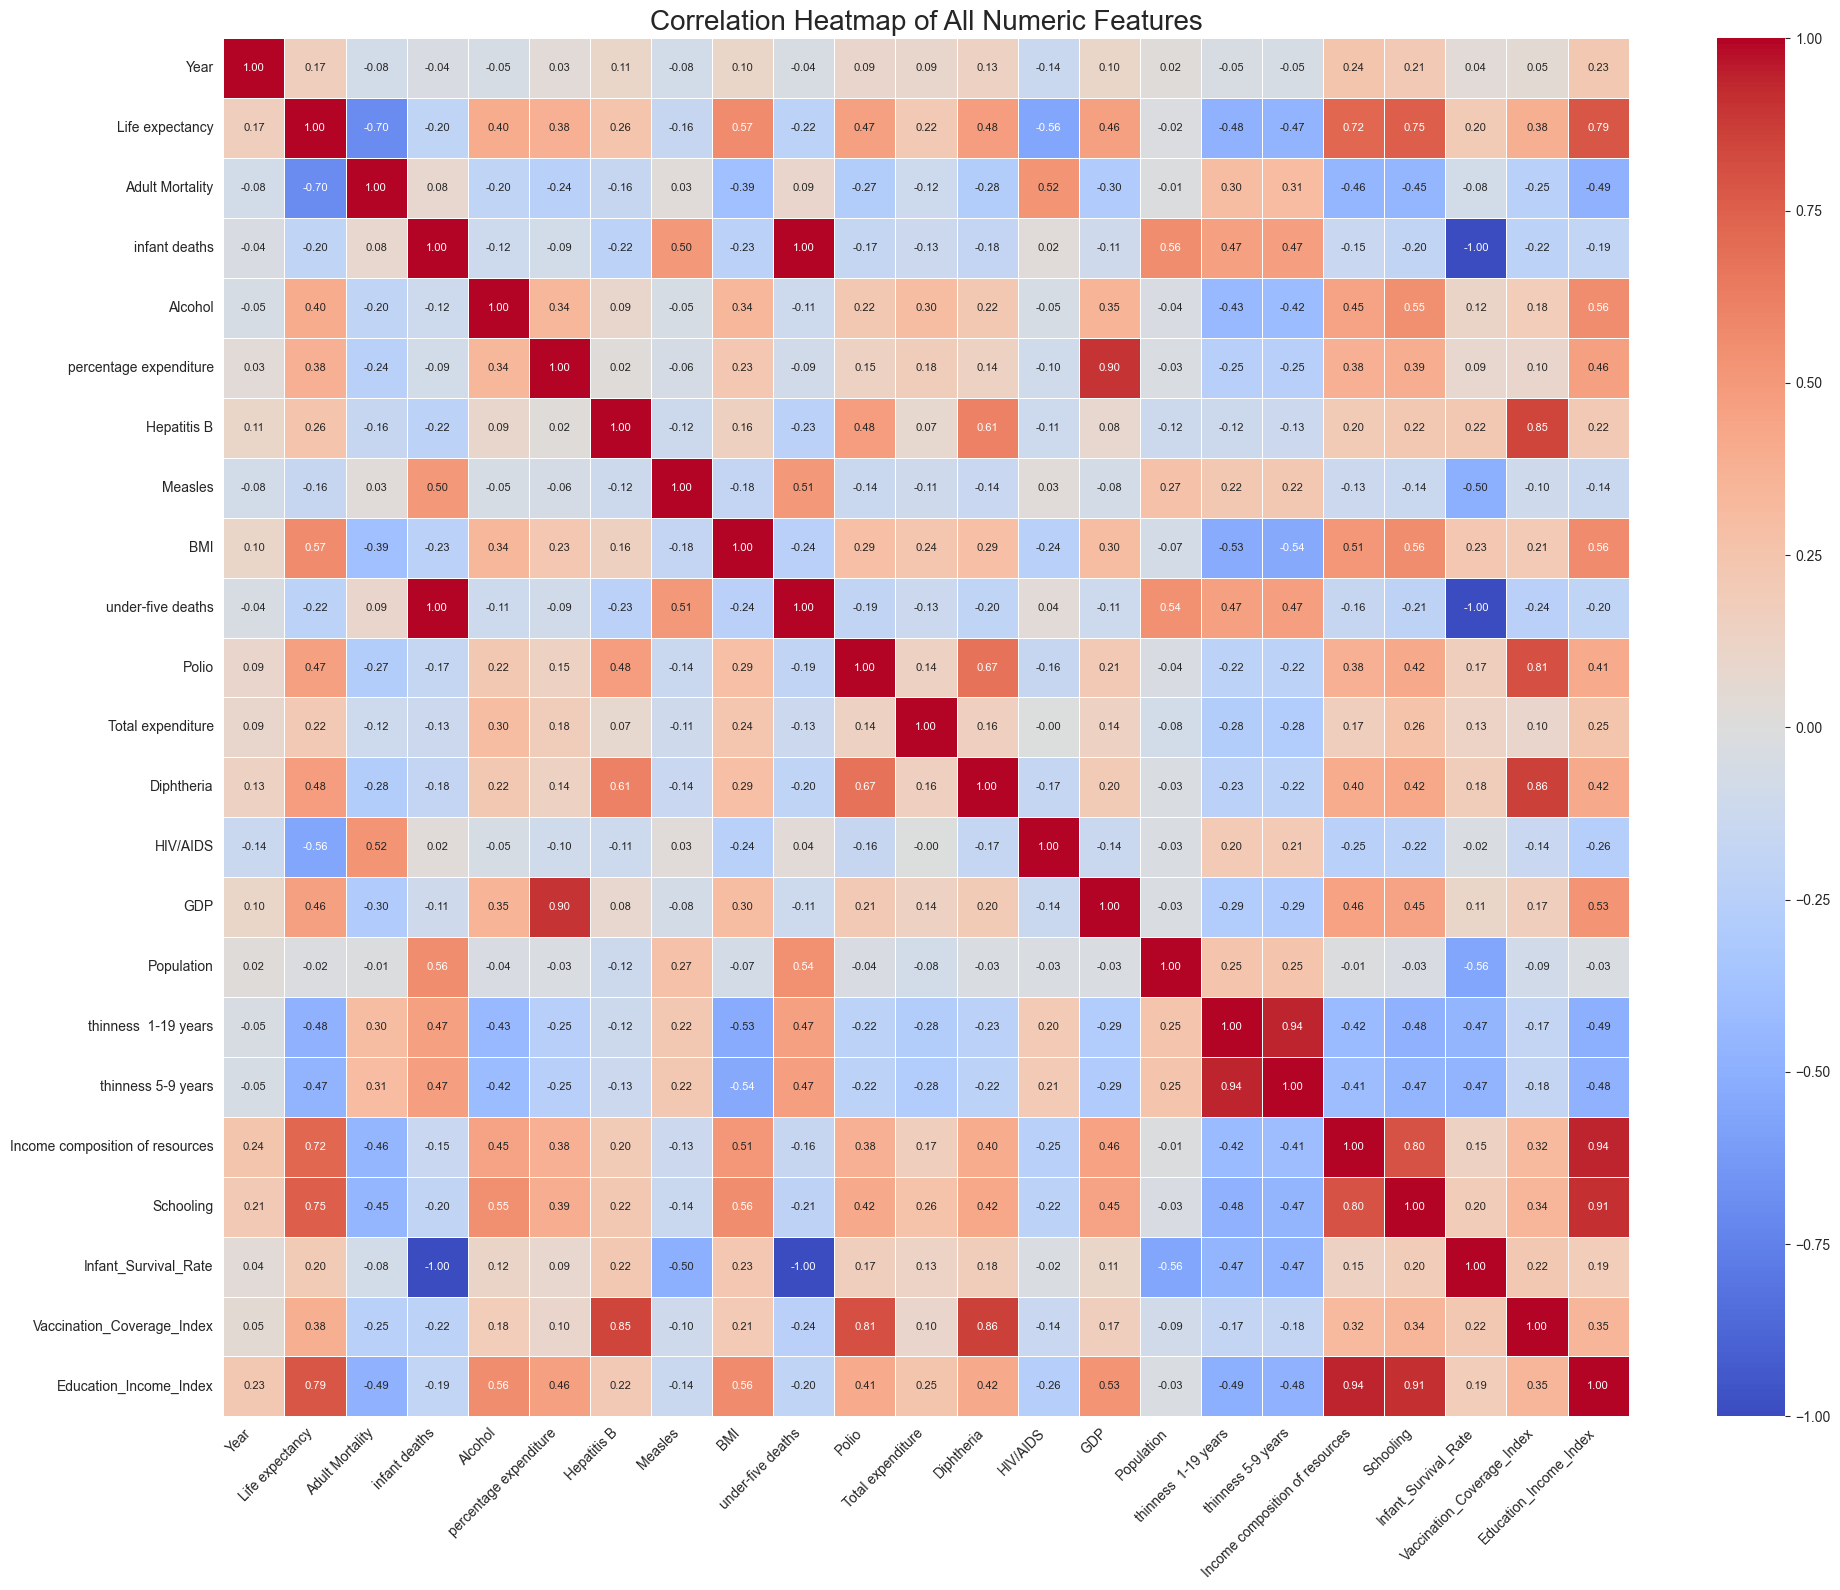

In [38]:
#  1. Create New Features 
print(" Q3: Part 1: Feature Engineering ")

# Feature 1: Infant Survival Rate
df['Infant_Survival_Rate'] = 1 - (df['infant deaths'] / 1000)

# Feature 2: Vaccination Coverage Index
df['Vaccination_Coverage_Index'] = (df['Hepatitis B'] + df['Polio'] + df['Diphtheria']) / 3

# Feature 3: Education Income Index
df['Education_Income_Index'] = df['Schooling'] * df['Income composition of resources']
new_features = ["Infant_Survival_Rate", "Vaccination_Coverage_Index", "Education_Income_Index"]
print("Created new features: 'Infant_Survival_Rate', 'Vaccination_Coverage_Index', 'Education_Income_Index'")
display(df[new_features].head())

#  3. Plot Feature Distributions by Status 
print("\n Q3: Part 2: Plotting Feature Distributions ")

features_to_plot = ['Adult Mortality', 'GDP', 'Schooling', 'Alcohol', 'Vaccination_Coverage_Index']

plt.figure(figsize=(15, 12))
plt.suptitle('Distribution of Features by Country Status', fontsize=18, y=1.02)

for i, feature in enumerate(features_to_plot):
    plt.subplot(3, 2, i + 1)
    sns.kdeplot(data=df, x=feature, hue='Status', fill=True, common_norm=False, palette="deep")
    
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    if feature == 'GDP':
        plt.xscale('log')
        plt.title('Distribution of GDP (Log Scale)', fontsize=14)
        plt.xlabel('GDP (Log Scale)', fontsize=12)

plt.tight_layout()

#  4. Correlation Heatmap 
print("\n Q3: Part 3: Correlation Analysis ")

numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Heatmap of All Numeric Features', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()


#  5. Report Strongest Correlations with 'Life expectancy' 
print("\n Correlations with 'Life expectancy' ")

life_exp_corr = corr_matrix['Life expectancy'].sort_values(ascending=False)

print("\nStrongest Positive Correlations:")

print(life_exp_corr[1:6].to_frame(name="Positive Corr.").to_markdown())

print("\nStrongest Negative Correlations:")
print(life_exp_corr.tail(5).to_frame(name="Negative Corr.").to_markdown())

# QUestion 4


In [39]:

#  1. Define Target (y) and Features (X) 
# We use .copy() to avoid SettingWithCopyWarning
y = df['Life expectancy'].copy()
X = df.drop(columns=['Life expectancy', 'Country']).copy()
print(f"Target 'y' shape: {y.shape}")
print(f"Features 'X' shape: {X.shape}")

#  2. Create Preprocessing Pipelines 
# Identify numerical and categorical features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['Status']

if 'Status' in numeric_features:
    numeric_features.remove('Status')

print(f"Found {len(numeric_features)} numeric features.")
print(f"Found {len(categorical_features)} categorical features.")

# Pipeline for numeric features:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features:
categorical_transformer = Pipeline(steps=[
   
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

#  3. Combine Pipelines with ColumnTransformer 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

#  4. Apply the Preprocessing 
X_processed = preprocessor.fit_transform(X)

# Get feature names after transformation
try:
    num_feature_names = numeric_features
    cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    
    all_feature_names = num_feature_names + list(cat_feature_names)
    
    print("\n Preprocessing Complete ")
    print(f"Final processed features 'X_processed' shape: {X_processed.shape}")
    print(f"Number of features after encoding: {len(all_feature_names)}")

    # Display the first 5 rows of the processed data (as a DataFrame)
    X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
    print("\nHead of processed data:")
    print(X_processed_df.head())

except Exception as e:
    print(f"\nCould not get feature names, just printing array shape.")
    print(f"Final processed features 'X_processed' shape: {X_processed.shape}")
    print("\nHead of processed data (as array):")
    print(X_processed[:5])
    


Target 'y' shape: (2928,)
Features 'X' shape: (2928, 23)
Found 22 numeric features.
Found 1 categorical features.

 Preprocessing Complete 
Final processed features 'X_processed' shape: (2928, 23)
Number of features after encoding: 23

Head of processed data:
       Year  Adult Mortality  infant deaths   Alcohol  percentage expenditure  \
0  1.626978         0.790238       0.267520 -1.158458               -0.336102   
1  1.410048         0.854614       0.284455 -1.158458               -0.334975   
2  1.193118         0.830473       0.301391 -1.158458               -0.335128   
3  0.976187         0.862660       0.326794 -1.158458               -0.332633   
4  0.759257         0.886801       0.343730 -1.158458               -0.368345   

   Hepatitis B   Measles       BMI  under-five deaths     Polio  ...  \
0    -0.674051 -0.110924 -0.954056           0.254061 -3.265007  ...   
1    -0.801557 -0.168570 -0.979165           0.272732 -1.044706  ...   
2    -0.716553 -0.173968 -1.004273   

## QUestion 5

In [40]:
print("\n Q5: Model Training and Tuning ")

# 2. Split Data (Step 1 of Q5 is the 'y' variable from above)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)
print(f"Split data into {len(X_train)} training and {len(X_test)} testing samples.")

# 3. Define Models and Parameter Grids
params_dt = {'max_depth': [5, 10, 15, None], 'min_samples_leaf': [1, 5, 10]}
params_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_leaf': [1, 5]}
params_knn = {'n_neighbors': [3, 5, 7, 11]}
params_gb = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}

# 4. Run GridSearchCV
models_to_tune = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42), params_dt),
    ('Random Forest', RandomForestRegressor(random_state=42), params_rf),
    ('KNN', KNeighborsRegressor(), params_knn),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42), params_gb)
]

best_models = {}
results_list = []

print("\nStarting GridSearchCV for 4 models... (This may take a few minutes)")

for name, model, params in models_to_tune:
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # 5. Evaluate on Test Set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_list.append({
        'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Best Params': grid_search.best_params_
    })
    best_models[name] = best_model

print("GridSearchCV complete.")

# 6. Report Results
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='R2', ascending=False)

print("\n Model Performance on Test Set ")
print(results_df[['Model', 'RMSE', 'MAE', 'R2']].to_markdown(index=False))

print("\n Best Hyperparameters Found ")
for result in results_df.to_dict('records'):
    print(f"Model: {result['Model']}")
    print(f"  Params: {result['Best Params']}")
    
# 7. Save the Best-Performing Model for Q6
best_model_name = results_df.iloc[0]['Model']
best_model_object = best_models[best_model_name]

# Save the model and feature names for Q6
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model_object, f)
    
with open('all_feature_names.pkl', 'wb') as f:
    pickle.dump(all_feature_names, f)
    
# Save X_test and y_test for Q6 as well
np.save('X_test_q6.npy', X_test)
y_test.to_csv('y_test_q6.csv', index=False, header=True)

# Save X_train and y_train for Q6
np.save('X_train_q6.npy', X_train)
y_train.to_csv('y_train_q6.csv', index=False, header=True)

# Save the list of models and their best params for Q6
with open('all_best_models_params.pkl', 'wb') as f:
    # Save just the params, as the models are easy to retrain
    best_params_dict = {r['Model']: r['Best Params'] for r in results_df.to_dict('records')}
    pickle.dump(best_params_dict, f)


 Q5: Model Training and Tuning 
Split data into 2342 training and 586 testing samples.

Starting GridSearchCV for 4 models... (This may take a few minutes)
Tuning Decision Tree...
Tuning Random Forest...
Tuning KNN...
Tuning Gradient Boosting...
GridSearchCV complete.

 Model Performance on Test Set 
| Model             |    RMSE |     MAE |       R2 |
|:------------------|--------:|--------:|---------:|
| Random Forest     | 1.7041  | 1.06064 | 0.966428 |
| Gradient Boosting | 1.85452 | 1.19324 | 0.96024  |
| Decision Tree     | 2.43043 | 1.56803 | 0.931711 |
| KNN               | 2.78821 | 1.80518 | 0.910125 |

 Best Hyperparameters Found 
Model: Random Forest
  Params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
Model: Gradient Boosting
  Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Model: Decision Tree
  Params: {'max_depth': 15, 'min_samples_leaf': 5}
Model: KNN
  Params: {'n_neighbors': 3}


# QUestion 6

In [47]:


#  1. Load Artifacts from Q5 

print("\n Loading Artifacts from Q5 ")

try:
    # Load the best model object
    with open('best_model.pkl', 'rb') as f:
        best_model_object = pickle.load(f)
    print(" Loaded best model")
    
    # Load feature names
    with open('all_feature_names.pkl', 'rb') as f:
        all_feature_names = pickle.load(f)
    print(f" Loaded {len(all_feature_names)} feature names")
    
    # Load best hyperparameters for all models (THIS IS A DICTIONARY)
    with open('all_best_models_params.pkl', 'rb') as f:
        best_params_dict = pickle.load(f)
    print(f" Loaded best parameters for {len(best_params_dict)} models")
    
    # Load test and train data
    X_train = np.load('X_train_q6.npy')
    X_test = np.load('X_test_q6.npy')
    y_train = pd.read_csv('y_train_q6.csv').iloc[:, 0]  # Extract column as Series
    y_test = pd.read_csv('y_test_q6.csv').iloc[:, 0]    # Extract column as Series
    
    print(f" Loaded X_train: {X_train.shape}")
    print(f" Loaded X_test: {X_test.shape}")
    print(f" Loaded y_train: {y_train.shape}")
    print(f" Loaded y_test: {y_test.shape}")
    
except Exception as e:
    print(f" Error loading artifacts: {e}")
    raise

#  2. Get Feature Importances from Best Model 

print("\n Extracting Feature Importances ")
print(f"Best model type: {type(best_model_object).__name__}")

# Check if the best model has feature importances
if hasattr(best_model_object, 'feature_importances_'):
    importances = best_model_object.feature_importances_
    model_for_importances = type(best_model_object).__name__
    print(f" Using feature importances from {model_for_importances}")
else:
    # If best model is KNN (no feature_importances_), use Random Forest instead
    print(f" Best model ({type(best_model_object).__name__}) has no feature importances")
    print("  Retraining Random Forest to get feature importances...")
    
    # Create and train Random Forest with its best hyperparameters
    rf_model = RandomForestRegressor(random_state=42)
    rf_best_params = best_params_dict['Random Forest']
    rf_model.set_params(**rf_best_params)
    rf_model.fit(X_train, y_train)
    
    importances = rf_model.feature_importances_
    best_model_object = rf_model
    model_for_importances = "Random Forest"
    print(f" Using feature importances from {model_for_importances}")

#  3. Select Top 10 Features 

print("\n Top 10 Most Important Features ")

# Create a Series of importances mapped to feature names
importance_series = pd.Series(importances, index=all_feature_names)
top_10_features = importance_series.sort_values(ascending=False).head(10)

# Display the top 10
print(top_10_features.to_frame(name="Feature Importance").to_string())

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')
plt.title('Top 10 Feature Importances from Best Model', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('q6_feature_importances.png', dpi=300, bbox_inches='tight')
print("\n Saved feature importance plot as 'q6_feature_importances.png'")
plt.close()

#  4. Create Reduced Feature Datasets 

print("\n Creating Reduced Feature Datasets ")

# Get the names and indices of top 10 features
top_10_names = top_10_features.index.tolist()
top_10_indices = [all_feature_names.index(name) for name in top_10_names]

# Slice the X data to keep only these 10 features
X_train_simple = X_train[:, top_10_indices]
X_test_simple = X_test[:, top_10_indices]

print(f"Original feature count: {X_train.shape[1]}")
print(f"Reduced feature count: {X_train_simple.shape[1]}")
print(f" X_train reduced: {X_train.shape} → {X_train_simple.shape}")
print(f" X_test reduced: {X_test.shape} → {X_test_simple.shape}")

#  5. Define Models to Train 

print("\n Setting Up Models ")

models_config = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

print(f" Configured {len(models_config)} models for training")

#  6. Train Models on FULL Dataset (23 Features) 

print("\n" + "=" * 80)
print("TRAINING MODELS ON FULL DATASET (23 Features)")
print("=" * 80)

full_model_results = {}

for model_name, model_template in models_config.items():
    try:
        print(f"\n{model_name}...")
        
        # Get the best parameters for this model from Q5
        if model_name not in best_params_dict:
            print(f"   No saved parameters found for {model_name}")
            continue
        
        best_params = best_params_dict[model_name]
        
        # Create a fresh model instance
        if model_name == 'Decision Tree':
            model_full = DecisionTreeRegressor(random_state=42)
        elif model_name == 'Random Forest':
            model_full = RandomForestRegressor(random_state=42)
        elif model_name == 'KNN':
            model_full = KNeighborsRegressor()
        else:  # Gradient Boosting
            model_full = GradientBoostingRegressor(random_state=42)
        
        # Set the best hyperparameters
        model_full.set_params(**best_params)
        
        # Train on full data
        model_full.fit(X_train, y_train)
        
        # Predict on test data
        y_pred_full = model_full.predict(X_test)
        
        # Calculate metrics
        rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_full))
        mae_full = mean_absolute_error(y_test, y_pred_full)
        r2_full = r2_score(y_test, y_pred_full)
        
        # Store results
        full_model_results[model_name] = {
            'RMSE': rmse_full,
            'MAE': mae_full,
            'R2': r2_full
        }
        
        print(f"   RMSE: {rmse_full:.4f}, MAE: {mae_full:.4f}, R²: {r2_full:.4f}")
        
    except Exception as e:
        print(f"   Error training {model_name}: {e}")
        import traceback
        traceback.print_exc()

#  7. Train Models on REDUCED Dataset (10 Features) 

print("\n" + "=" * 80)
print("TRAINING MODELS ON REDUCED DATASET (10 Features)")
print("=" * 80)

simple_model_results = {}

for model_name, model_template in models_config.items():
    try:
        print(f"\n{model_name}...")
        
        # Get the best parameters for this model
        if model_name not in best_params_dict:
            print(f"   No saved parameters found for {model_name}")
            continue
        
        best_params = best_params_dict[model_name]
        
        # Create a fresh model instance
        if model_name == 'Decision Tree':
            model_simple = DecisionTreeRegressor(random_state=42)
        elif model_name == 'Random Forest':
            model_simple = RandomForestRegressor(random_state=42)
        elif model_name == 'KNN':
            model_simple = KNeighborsRegressor()
        else:  # Gradient Boosting
            model_simple = GradientBoostingRegressor(random_state=42)
        
        # Set the best hyperparameters
        model_simple.set_params(**best_params)
        
        # Train on reduced data
        model_simple.fit(X_train_simple, y_train)
        
        # Predict on reduced test data
        y_pred_simple = model_simple.predict(X_test_simple)
        
        # Calculate metrics
        rmse_simple = np.sqrt(mean_squared_error(y_test, y_pred_simple))
        mae_simple = mean_absolute_error(y_test, y_pred_simple)
        r2_simple = r2_score(y_test, y_pred_simple)
        
        # Store results
        simple_model_results[model_name] = {
            'RMSE': rmse_simple,
            'MAE': mae_simple,
            'R2': r2_simple
        }
        
        print(f"   RMSE: {rmse_simple:.4f}, MAE: {mae_simple:.4f}, R²: {r2_simple:.4f}")
        
    except Exception as e:
        print(f"   Error training {model_name}: {e}")
        import traceback
        traceback.print_exc()

#  8. Compare Full vs. Reduced Models 

print("\n" + "=" * 80)
print("COMPARISON: FULL vs. REDUCED MODELS")
print("=" * 80)

# Convert to DataFrames
full_results_df = pd.DataFrame(full_model_results).T
simple_results_df = pd.DataFrame(simple_model_results).T

# Create multi-index columns for side-by-side comparison
full_results_df.columns = pd.MultiIndex.from_product([['Full (23 Feat)'], ['RMSE', 'MAE', 'R2']])
simple_results_df.columns = pd.MultiIndex.from_product([['Reduced (10 Feat)'], ['RMSE', 'MAE', 'R2']])

# Concatenate for side-by-side comparison
comparison_df = pd.concat([full_results_df, simple_results_df], axis=1)

print("\n" + comparison_df.to_string(float_format=lambda x: f'{x:.4f}'))

# Save comparison table
comparison_df.to_csv('q6_model_comparison.csv')
print("\n Saved model comparison to 'q6_model_comparison.csv'")

#  9. Calculate and Display Performance Degradation 

print("\n" + "=" * 80)
print("PERFORMANCE DEGRADATION ANALYSIS")
print("=" * 80)

for model_name in full_model_results.keys():
    if model_name not in simple_model_results:
        print(f"\n{model_name}: (Not trained on reduced dataset)")
        continue
    
    r2_full = full_model_results[model_name]['R2']
    r2_simple = simple_model_results[model_name]['R2']
    r2_loss = r2_full - r2_simple
    r2_loss_pct = (r2_loss / r2_full) * 100 if r2_full != 0 else 0
    
    rmse_full = full_model_results[model_name]['RMSE']
    rmse_simple = simple_model_results[model_name]['RMSE']
    rmse_increase = rmse_simple - rmse_full
    rmse_increase_pct = (rmse_increase / rmse_full) * 100 if rmse_full != 0 else 0
    
    print(f"\n{model_name}:")
    print(f"  R² Score:     {r2_full:.4f} → {r2_simple:.4f} (loss: {r2_loss:.4f} or {r2_loss_pct:.2f}%)")
    print(f"  RMSE:         {rmse_full:.4f} → {rmse_simple:.4f} (increase: {rmse_increase:.4f} or {rmse_increase_pct:.2f}%)")




 Loading Artifacts from Q5 
 Loaded best model
 Loaded 23 feature names
 Loaded best parameters for 4 models
 Loaded X_train: (2342, 23)
 Loaded X_test: (586, 23)
 Loaded y_train: (2342,)
 Loaded y_test: (586,)

 Extracting Feature Importances 
Best model type: RandomForestRegressor
 Using feature importances from RandomForestRegressor

 Top 10 Most Important Features 
                                 Feature Importance
HIV/AIDS                                   0.528772
Income composition of resources            0.230230
Adult Mortality                            0.118776
BMI                                        0.019990
Education_Income_Index                     0.015915
Schooling                                  0.012908
Alcohol                                    0.009680
thinness 5-9 years                         0.008726
under-five deaths                          0.007327
Year                                       0.006800

 Saved feature importance plot as 'q6_feature_importan

## Question 7 


 Comparison: Model Importance vs. Simple Correlation 
| Feature                         |   Importance |   Correlation |
|:--------------------------------|-------------:|--------------:|
| HIV/AIDS                        |       0.5288 |       -0.5566 |
| Income composition of resources |       0.2302 |        0.7217 |
| Adult Mortality                 |       0.1188 |       -0.6964 |
| BMI                             |       0.0200 |        0.5695 |
| Education_Income_Index          |       0.0159 |        0.7814 |
| Schooling                       |       0.0129 |        0.7497 |
| Alcohol                         |       0.0097 |        0.4168 |
| thinness 5-9 years              |       0.0087 |       -0.4736 |
| under-five deaths               |       0.0073 |       -0.2225 |
| Year                            |       0.0068 |        0.1700 |

Saved comparison plot as 'q7_importance_vs_correlation.png'

 Top 5 Features for Discussion 
['HIV/AIDS', 'Income composition of resources',

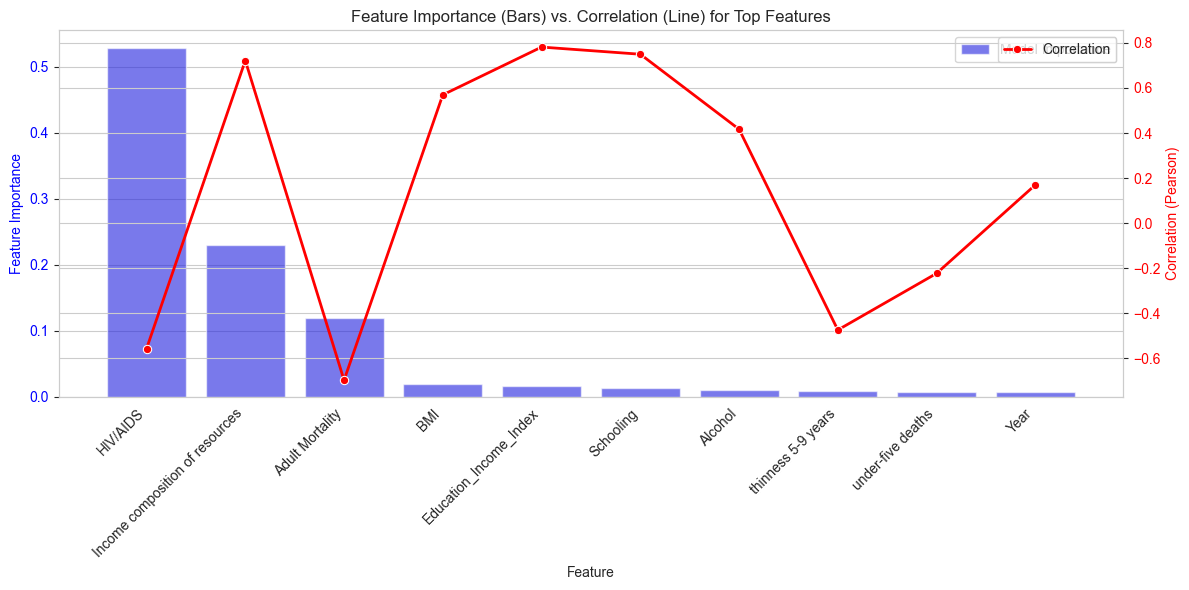

In [ ]:

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#  4. Calculate Simple Correlations (using processed data for apples-to-apples comparison) 
# We create a dataframe of the processed data to calculate correlations
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
X_processed_df['Life expectancy'] = y.values

# Calculate correlation of each feature with target
correlations = X_processed_df.corr()['Life expectancy'].drop('Life expectancy')
feature_importance_df['Correlation'] = feature_importance_df['Feature'].map(correlations)
feature_importance_df['Abs_Correlation'] = feature_importance_df['Correlation'].abs()

#  5. Create Comparison Table 
print("\n Comparison: Model Importance vs. Simple Correlation ")
print(feature_importance_df[['Feature', 'Importance', 'Correlation']].head(10).to_markdown(index=False, floatfmt=".4f"))

#  6. Plotting the Comparison 
top_10 = feature_importance_df.head(10)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Feature Importance
sns.barplot(data=top_10, x='Feature', y='Importance', alpha=0.6, color='blue', ax=ax1, label='Model Importance')
ax1.set_ylabel('Feature Importance', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Line plot for Correlation
ax2 = ax1.twinx()
sns.lineplot(data=top_10, x='Feature', y='Correlation', marker='o', color='red', ax=ax2, label='Correlation', linewidth=2)
ax2.set_ylabel('Correlation (Pearson)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Feature Importance (Bars) vs. Correlation (Line) for Top Features')
plt.tight_layout()
plt.savefig('q7_importance_vs_correlation.png')
print("\nSaved comparison plot as 'q7_importance_vs_correlation.png'")

#  7. Extract Top 5 for Report 
print("\n Top 5 Features for Discussion ")
print(feature_importance_df['Feature'].head(5).to_list())